In [1]:
# 查看paste提供的数据和原始数据的区别
import scanpy as sc
sample = '151507'
data1 = sc.read_h5ad('D:/bio/paste/paste_reproducibility-main/data/DLPFC/{0}_preprocessed.h5'.format(sample))
print(data1)
data2 = sc.read_visium('D:/dataset/151507')
print(data2)

AnnData object with n_obs × n_vars = 4220 × 9948
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'layer_guess_reordered_colors'
    obsm: 'spatial'


D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\envs\PASTE\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
#%load_ext autoreload
#%autoreload 2
# style.use('seaborn-dark')
style.use('seaborn-white')

C:\Users\23147\AppData\Local\Temp\ipykernel_4684\1371196749.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def plot2D_samples_mat(xs, xt, G, thr=1e-8,alpha=0.2,top=1000,weight_alpha=False,**kwargs):
    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    idx = largest_indices(G,top)
    for l in range(len(idx[0])):
        plt.plot([xs[idx[0][l], 0], xt[idx[1][l], 0]], [xs[idx[0][l], 1], xt[idx[1][l], 1]],alpha=alpha*(1-weight_alpha)+(weight_alpha*G[idx[0][l],idx[1][l]] /mx),c='k')

    
def plot_slice_pairwise_alignment(slice1,slice2,pi,thr=1-1e-8,alpha=0.05,top=1000,name='',save=False,weight_alpha=False):
    coordinates1,coordinates2 = slice1.obsm['spatial'],slice2.obsm['spatial']
    offset = (coordinates1[:,0].max()-coordinates2[:,0].min())*1.1
    temp = np.zeros(coordinates2.shape)
    temp[:,0] = offset
    plt.figure(figsize=(20,10))
    plot2D_samples_mat(coordinates1, coordinates2+temp, pi,thr=thr, c='k',alpha=alpha,top=top,weight_alpha=weight_alpha)
    plt.scatter(coordinates1[:,0],coordinates1[:,1],linewidth=0,s=100, marker=".",color=list(slice1.obs['layer_guess_reordered'].map(dict(zip(slice1.obs['layer_guess_reordered'].cat.categories,slice1.uns['layer_guess_reordered_colors'])))))
    plt.scatter(coordinates2[:,0]+offset,coordinates2[:,1],linewidth=0,s=100, marker=".",color=list(slice2.obs['layer_guess_reordered'].map(dict(zip(slice2.obs['layer_guess_reordered'].cat.categories,slice2.uns['layer_guess_reordered_colors'])))))
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()

## Organize data

In [4]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('D:/bio/paste/paste_reproducibility-main/data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

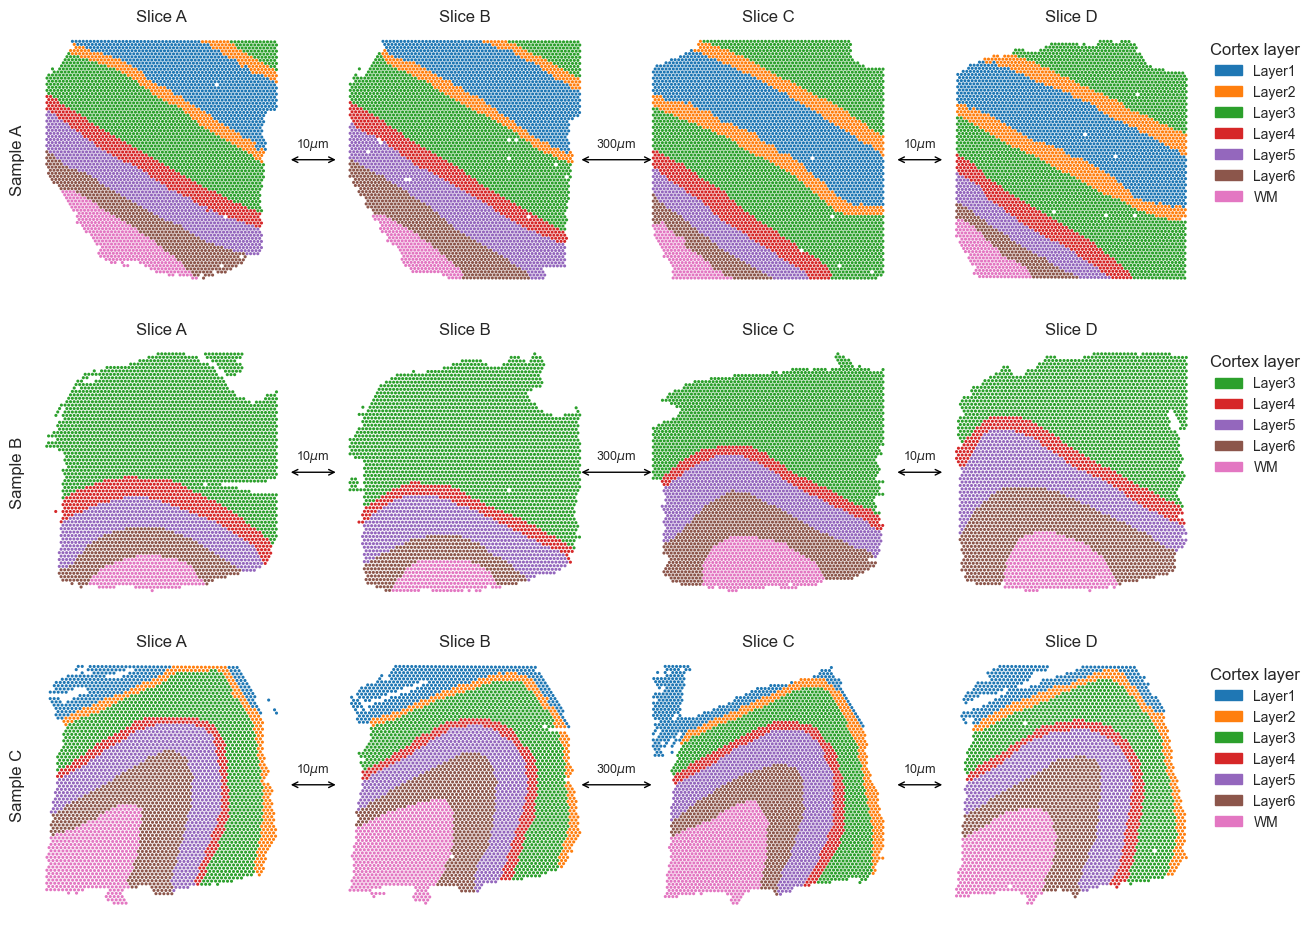

In [4]:
slice_map = {0:'A',1:'B',2:'C',3:'D'}
fig, axs = plt.subplots(3, 4,figsize=(15,11.5))
for j in range(len(layer_groups)):
    axs[j,0].text(-0.1, 0.5, 'Sample '+slice_map[j],fontsize=12,rotation='vertical',transform = axs[j,0].transAxes,verticalalignment='center')
    for i in range(len(layer_groups[j])):
        adata = adatas[sample_list[j*4+i]]
        colors = list(adata.obs['layer_guess_reordered'].astype('str').map(layer_to_color_map))
        axs[j,i].scatter(layer_groups[j][i].obsm['spatial'][:,0],layer_groups[j][i].obsm['spatial'][:,1],linewidth=0,s=20, marker=".",color=colors)
        axs[j,i].set_title('Slice '+ slice_map[i],size=12)
        axs[j,i].invert_yaxis()
        axs[j,i].axis('off')
        if i<3:
            s = '300$\mu$m' if i==1 else "10$\mu$m"
            delta = 0.05 if i==1 else 0
            axs[j,i].annotate('',xy=(1-delta, 0.5), xytext=(1.2+delta, 0.5),xycoords=axs[j,i].transAxes,textcoords=axs[j,i].transAxes,arrowprops=dict(arrowstyle='<->',lw=1))
            axs[j,0].text(1.1, 0.55, s,fontsize=9,transform = axs[j,i].transAxes,horizontalalignment='center')
    axs[j,3].legend(handles=[mpatches.Patch(color=layer_to_color_map[adata.obs['layer_guess_reordered'].cat.categories[i]], label=adata.obs['layer_guess_reordered'].cat.categories[i]) for i in range(len(adata.obs['layer_guess_reordered'].cat.categories))],fontsize=10,title='Cortex layer',title_fontsize=12,bbox_to_anchor=(1, 1))

# Pairwise Alignment

### Run PASTE `pairwise_align`.

In [5]:
def max_accuracy(labels1,labels2):
    w = min(1/len(labels1),1/len(labels2))
    cats = set(pd.unique(labels1)).union(set(pd.unique(labels1)))
    return sum([w * min(sum(labels1==c),sum(labels2==c)) for c in cats])
def mapping_accuracy(labels1,labels2,pi):
    mapping_dict = {'Layer1':1, 'Layer2':2, 'Layer3':3, 'Layer4':4, 'Layer5':5, 'Layer6':6, 'WM':7}
    return np.sum(pi*(scipy.spatial.distance_matrix(np.matrix(labels1.map(mapping_dict) ).T,np.matrix(labels2.map(mapping_dict)).T)==0))
import itertools
def max_accuracy_mapping(labels1,labels2):
    n1,n2=len(labels1),len(labels2)
    mapping_dict = {'Layer1':1, 'Layer2':2, 'Layer3':3, 'Layer4':4, 'Layer5':5, 'Layer6':6, 'WM':7}
    dist = np.array(scipy.spatial.distance_matrix(np.matrix(labels1.map(mapping_dict)).T,np.matrix(labels2.map(mapping_dict)).T)!=0,dtype=float)
    pi = ot.emd(np.ones(n1)/n1, np.ones(n2)/n2, dist)
    return pi

Uncomment the following cell if you want to generate from scratch the PASTE DLPFC alignments

In [6]:
%%time

alpha = 0.1
res_df = pd.DataFrame(columns=['Sample','Pair','Kind','Time','Accuracy'])
pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
   for i in range(len(layer_groups[j])-1):
       pi0 = pst.match_spots_using_spatial_heuristic(layer_groups[j][i].obsm['spatial'],layer_groups[j][i+1].obsm['spatial'],use_ot=True)
       start = time.time()
       pis[j][i] = pst.pairwise_align(layer_groups[j][i], layer_groups[j][i+1],alpha=alpha,G_init=pi0,norm=True,verbose=False)
       tt = time.time()-start
       acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],pis[j][i])
       print(j,i,'Accuracy',acc,'time',tt)
       np.savetxt('D:/dataset/output/PASTE/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), pis[j][i], delimiter=',')
       res_df.loc[len(res_df)] = [j,i,'PASTE',tt,acc]

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
0 0 Accuracy 0.8157599443271348 time 23.110360383987427
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


D:\anaconda\envs\PASTE\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


0 1 Accuracy 0.2201553743901925 time 26.861592054367065
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


D:\anaconda\envs\PASTE\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


0 2 Accuracy 0.8666022688098282 time 28.655293464660645
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
1 0 Accuracy 0.9111987839539789 time 91.33132147789001
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


D:\anaconda\envs\PASTE\lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


1 1 Accuracy 0.5914551028329446 time 40.58307433128357
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
1 2 Accuracy 0.862209309341925 time 21.41085124015808
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
2 0 Accuracy 0.8595856234789299 time 66.2608573436737
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
2 1 Accuracy 0.8283176508072262 time 146.83250308036804
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
2 2 Accuracy 0.8284609511149533 time 154.48930978775024
CPU times: total: 1h 3min 39s
Wall time: 12min 5s


Read in saved PASTE DLPFC alignments

In [7]:
pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        pis[j][i]=np.loadtxt('D:/dataset/output/PASTE/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), delimiter=',')
        start = time.time()
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],pis[j][i])
        tt = time.time()-start
        print(j,i,'Accuracy',acc,'time',tt)
        res_df.loc[len(res_df)] = [j,i,'PASTE',tt,acc]

0 0 Accuracy 0.8157599443271348 time 0.22041058540344238
0 1 Accuracy 0.2201553743901925 time 0.25332212448120117
0 2 Accuracy 0.8666022688098282 time 0.44879746437072754
1 0 Accuracy 0.9111987839539789 time 0.26329517364501953
1 1 Accuracy 0.5914551028329446 time 0.18247699737548828
1 2 Accuracy 0.862209309341925 time 0.3261275291442871
2 0 Accuracy 0.8595856234789299 time 0.1685490608215332
2 1 Accuracy 0.8283176508072262 time 0.27028822898864746
2 2 Accuracy 0.8284609511149533 time 0.2513463497161865


## Rotate and plot new coordinates

In [8]:
paste_layer_groups = [pst.stack_slices_pairwise(layer_groups[j], pis[j]) for j in range(len(layer_groups)) ]

In [9]:
def plot_slices_overlap(groups, adatas, sample_list, layer_to_color_map):
    for j in range(len(groups)): 
        plt.figure(figsize=(10,10))
        for i in range(len(groups[j])):
            adata = adatas[sample_list[j*4+i]]
            colors = list(adata.obs['layer_guess_reordered'].astype('str').map(layer_to_color_map))
            plt.scatter(groups[j][i].obsm['spatial'][:,0],groups[j][i].obsm['spatial'][:,1],linewidth=0,s=100, marker=".",color=colors)
        plt.legend(handles=[mpatches.Patch(color=layer_to_color_map[adata.obs['layer_guess_reordered'].cat.categories[i]], label=adata.obs['layer_guess_reordered'].cat.categories[i]) for i in range(len(adata.obs['layer_guess_reordered'].cat.categories))],fontsize=10,title='Cortex layer',title_fontsize=15,bbox_to_anchor=(1, 1))
        plt.gca().invert_yaxis()
        plt.axis('off') 
        plt.show()

Below we plot stacking all slices of each DLPFC sample wihout alignment and with PASTE alignment. We also showcase how the STUtility alignment compares later in the notebook when we benchmark against other methods. 

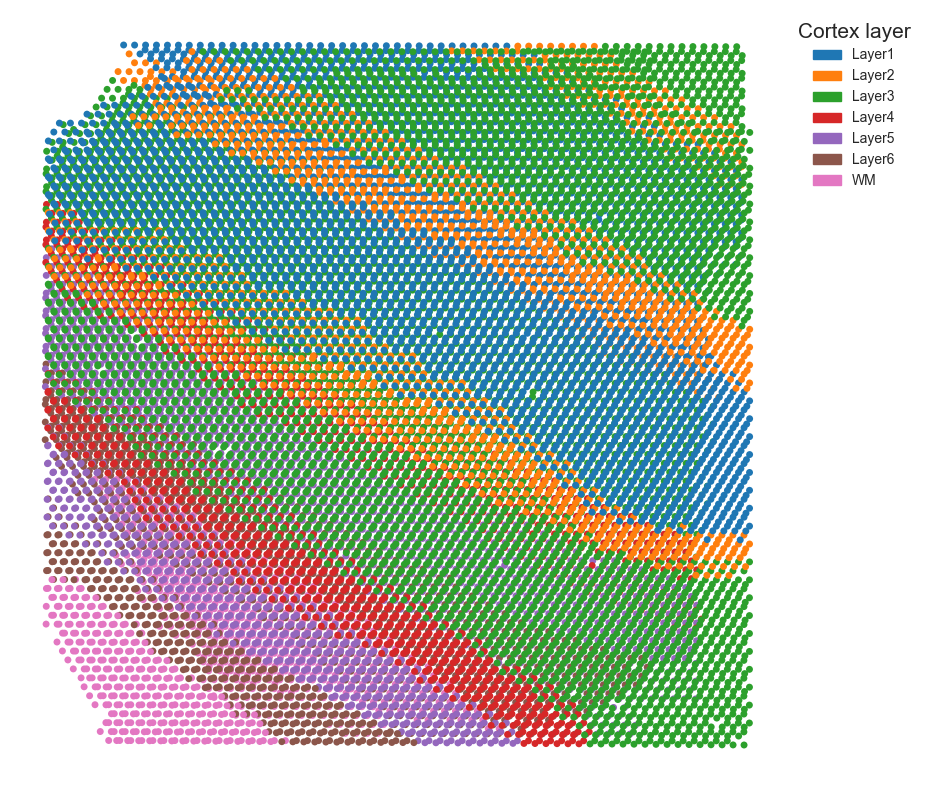

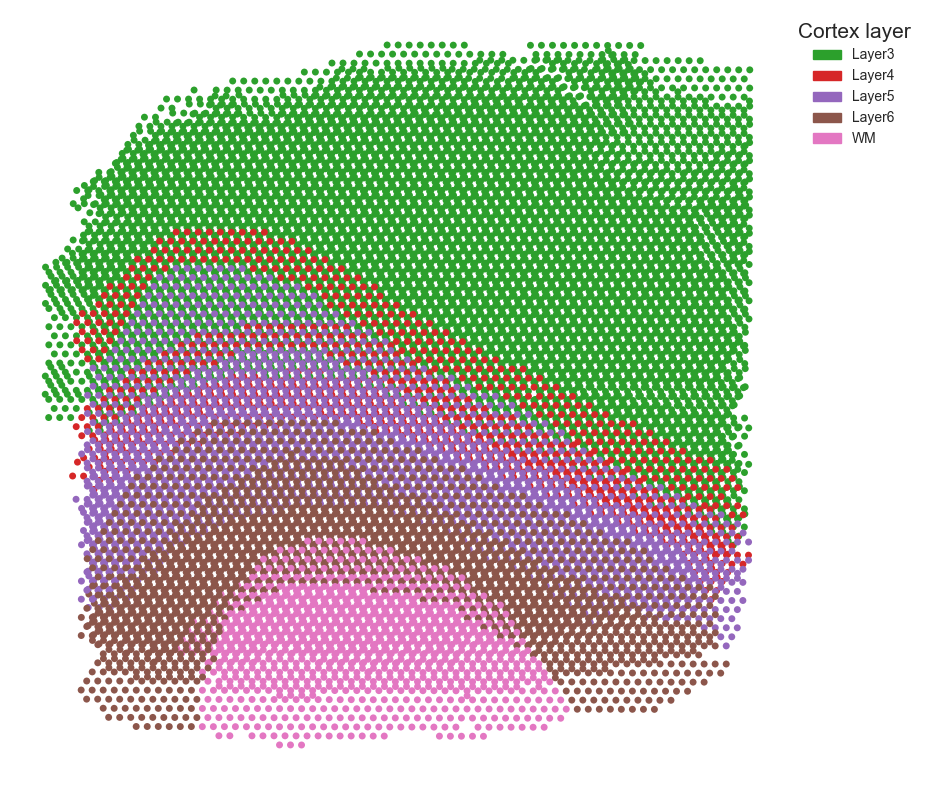

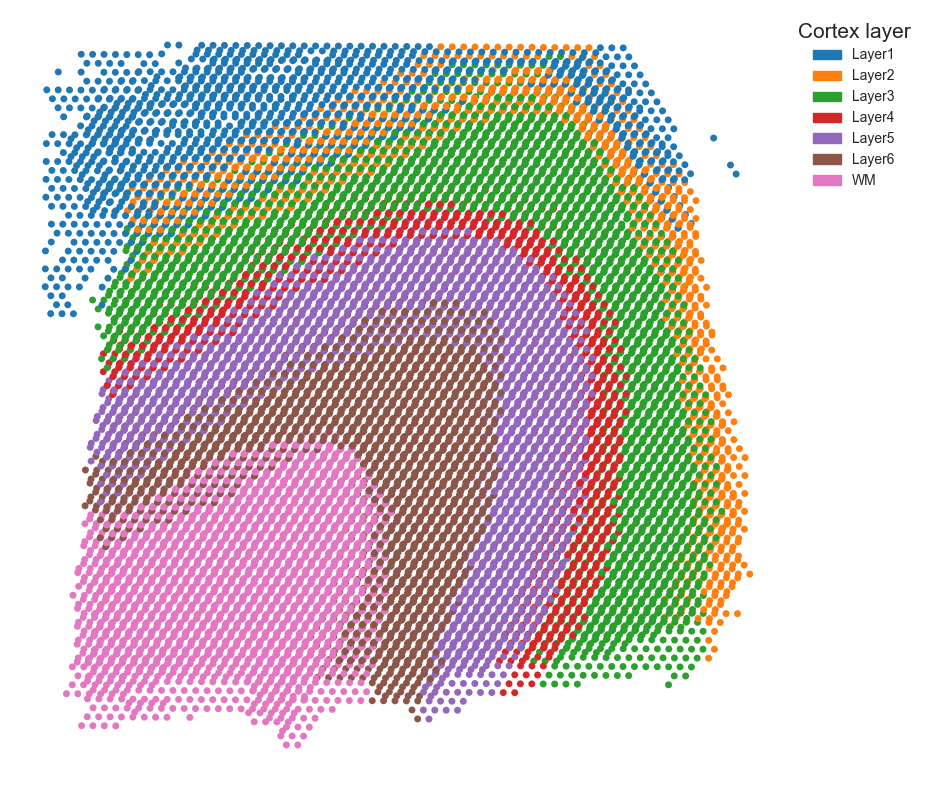

In [10]:
# Plot Stacking of Four slices without alignment
plot_slices_overlap(layer_groups, adatas, sample_list, layer_to_color_map)

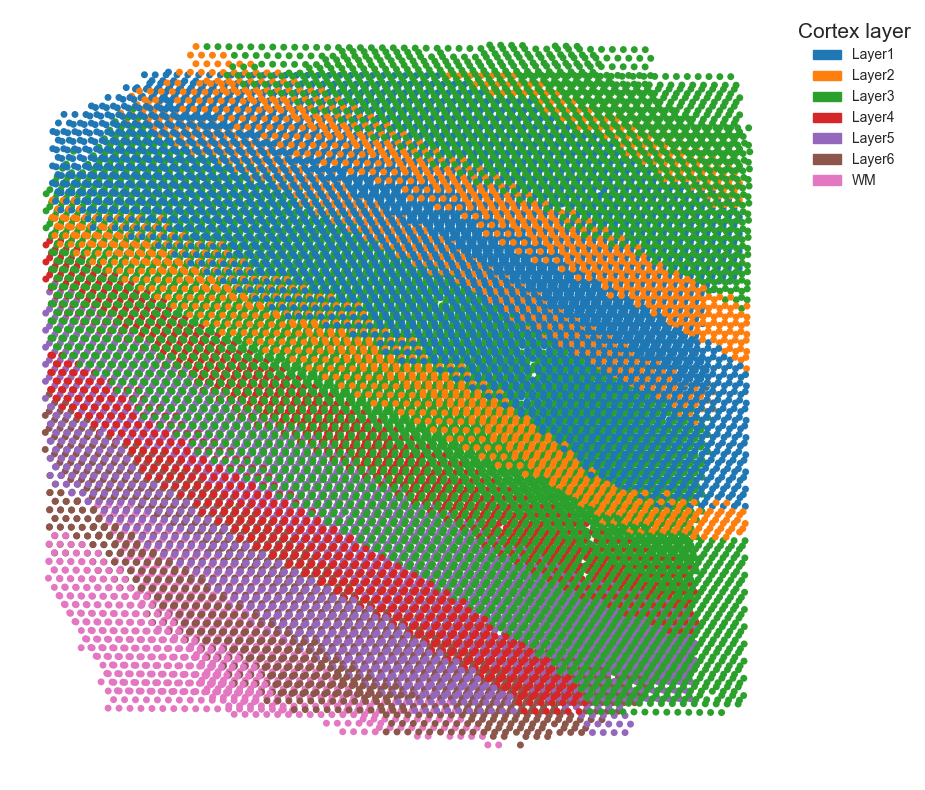

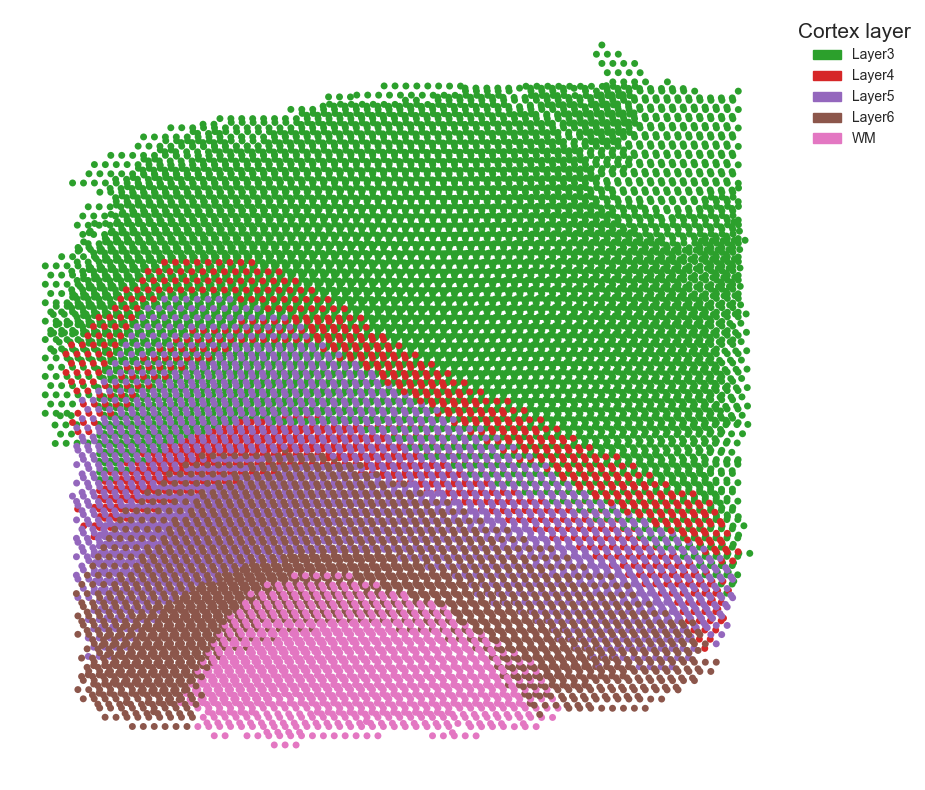

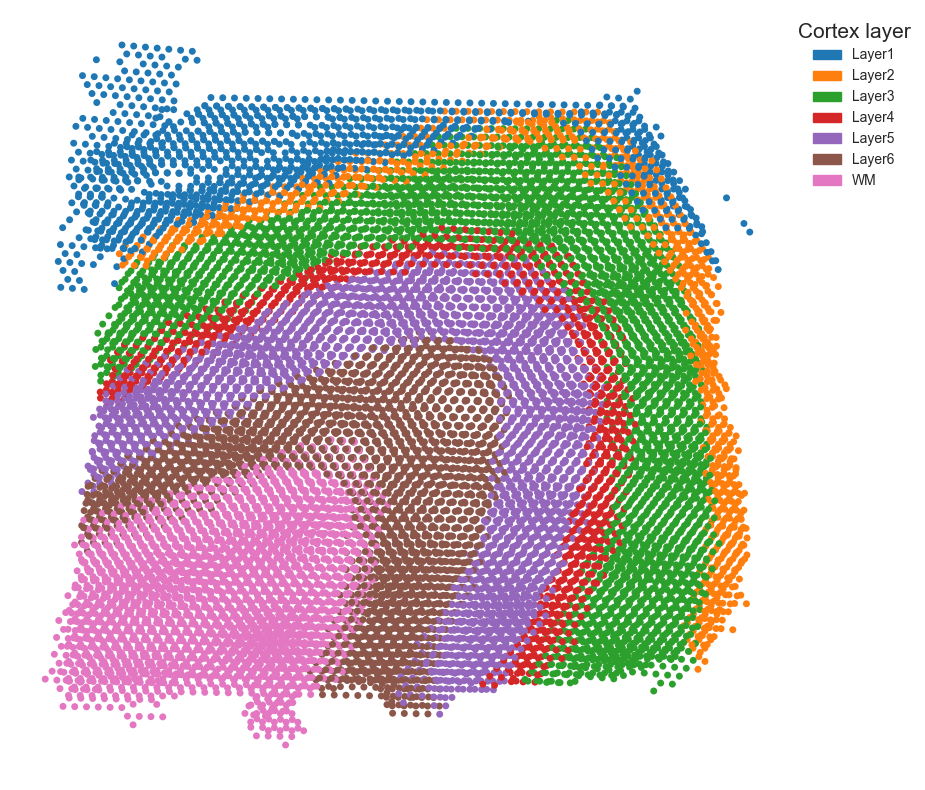

In [11]:
# Plot Stacking of Four slices with PASTE alignment
plot_slices_overlap(paste_layer_groups, adatas, sample_list, layer_to_color_map)

In [27]:
# print(len(paste_layer_groups[0][0].obsm['spatial'][:,1]))

for j in range(len(paste_layer_groups)): 
    for i in range(len(paste_layer_groups[j])):
        df = pd.DataFrame(
            {
                "spot": paste_layer_groups[j][i].obs.index,
                "aligned_x": paste_layer_groups[j][i].obsm['spatial'][:,0],
                "aligned_y": paste_layer_groups[j][i].obsm['spatial'][:,1],
            }
        )
        df.to_csv('D:/dataset/output/PASTE/'+sample_groups[j][i]+'.csv', sep=',')

In [ ]:
import plotly.express as px
import plotly.io as pio
# if using plain jupyter notebook use:
# pio.renderers.default='notebook'
# If using jupyterlab use:
pio.renderers.default='jupyterlab'
config = {
      'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': "DLPFC_3d"
      }
    }

factor = 6.1656/100
z_difference = [np.array([0,10,300,10])*factor for j in range(len(paste_layer_groups))]
z_coordinates = [[z_difference[j][:i+1].sum() for i in range(len(z_difference[j]))] for j in range(len(z_difference))]
z_coordinates = np.array([[0,1,2,3] for j in range(3)])*75

for j in range(len(paste_layer_groups)): 
    df = pd.DataFrame(columns=['x','y','z','layer'])
    for i,L in enumerate(paste_layer_groups[j]):
        adata = adatas[sample_list[j*4+i]]
        df_ = pd.DataFrame(np.concatenate((L.obsm['spatial'],np.matrix(z_coordinates[j][i]*np.ones(len(adata))).T,np.matrix(np.ones(len(adata),dtype=int)).T),axis=1),columns=['x','y','z','layer'])
        df_.loc[:,"layer"] = list(adata.obs['layer_guess_reordered'])
        df = df.append(df_, ignore_index=True)
    df = df.sort_values(by=['layer'])
    df['y'] = -df['y']
    df[['x','y','z']] = df[['x','y','z']]/factor
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color='layer',color_discrete_sequence=[matplotlib.colors.to_hex(layer_to_color_map[c]) for c in sorted(list(adata.obs['layer_guess_reordered'].cat.categories))])#adata.uns['layer_guess_reordered_colors'])
    fig.update_layout(scene_aspectmode='data',font=dict(size=8))
    fig.show(config=config)

## Benchmarks

Uncomment out the following two cells if you want to run tangram benchmark: warning it takes a very long time on a laptop (>6hours). 

In [ ]:
#import tangram as tg
#def align_tg(slice1,slice2,num_epochs=1000,density_prior=None,random_state=None):
#    ad_sp = slice2.copy()
#    ad_sc = slice1.copy()
#    tg.pp_adatas(ad_sc, ad_sp, genes=None)
#     ad_map = tg.map_cells_to_space(ad_sc, ad_sp, num_epochs=num_epochs,density_prior=density_prior,random_state=random_state)
#     return ad_map
# tangram_pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
# for j in range(len(layer_groups)):
#     for i in range(len(layer_groups[j])-1):
#         start = time.time()
#         tangram_pis[j][i] = align_tg(layer_groups[j][i],layer_groups[j][i+1],num_epochs=300,density_prior='uniform',random_state=0)
#         tt = time.time()-start
#         tangram_pis[j][i] = tangram_pis[j][i].X/tangram_pis[j][i].X.sum()
#         acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],tangram_pis[j][i])
#         res_df.loc[len(res_df)] = [j,i,'Tangram',tt,acc]

In [ ]:
#import pickle
#outfile = open('../data/DLPFC/saved_results/tangram_pis.pickle','wb')
#pickle.dump(tangram_pis,outfile)
#outfile.close()

In [ ]:
tangram_pis = pd.read_pickle(r'D:/bio/paste/paste_reproducibility-main/data/DLPFC/saved_results/tangram_pis.pickle')
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        start = time.time()
        tangram_pis[j][i] = tangram_pis[j][i]
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],tangram_pis[j][i])
        tt = time.time()-start
        res_df.loc[len(res_df)] = [j,i,'Tangram',tt,acc]

In [ ]:
seurat_anchors = {}
seurat_pis = [[0,0,0],[0,0,0],[0,0,0]]
for j in range(3):
    seurat_anchors[j] = pd.read_csv('D:/bio/paste/paste_reproducibility-main/data/DLPFC/saved_results/sample{0}-anchors.csv'.format(j+1))
    for i in range(3):
        temp = seurat_anchors[j][(seurat_anchors[j]['dataset1']==i+1)&((seurat_anchors[j]['dataset2']==i+2))]
        seurat_pi = np.zeros((len(layer_groups[j][i]),len(layer_groups[j][i+1])))
        for k in range(len(temp)):
            seurat_pi[int(temp.iloc[k]['cell1'])-1,int(temp.iloc[k]['cell2'])-1] = float(temp.iloc[k]['score'])
        seurat_pis[j][i] = seurat_pi/seurat_pi.sum()
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],seurat_pis[j][i])
        res_df.loc[len(res_df)] = [j,i,'Seurat',-1,acc]

In [ ]:
stutility_slices = [[None for i in range(len(layer_groups[j]))] for j in range(len(layer_groups))]
for j in range(len(layer_groups)): 
    for i in range(len(layer_groups[j])):
        stutility_slices[j][i] = layer_groups[j][i].copy()
        stu_coord = pd.read_csv('D:/bio/paste/paste_reproducibility-main/data/DLPFC/saved_results/{0}-STUtil-coords-default.csv'.format(sample_list[j*4+i]),sep=',',index_col=0)
        temp = stutility_slices[j][i].obs.index.copy()
        temp = temp.map(lambda x: x.split('.')[0])
        mat_df = stu_coord[stu_coord['barcode']==temp].reset_index()[['align_x','align_y']]
        stutility_slices[j][i].obsm['spatial'] = mat_df.to_numpy()
        
stu_pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)): 
    for i in range(len(layer_groups[j])-1):
        pi0 = np.loadtxt('D:/bio/paste/paste_reproducibility-main/data/DLPFC/saved_results/{0}-{1}-stutil-alignment.csv'.format(sample_list[j*4+i],sample_list[j*4+i+1]), delimiter=',')
        stu_pis[j][i] = pi0
        acc = mapping_accuracy(stutility_slices[j][i].obs['layer_guess_reordered'],stutility_slices[j][i+1].obs['layer_guess_reordered'],stu_pis[j][i])
        print(acc,end=', ') 
        res_df.loc[len(res_df)] = [j,i,'STUtility',-1,acc]

In [ ]:
plot_slices_overlap(stutility_slices, adatas, sample_list, layer_to_color_map)

In [ ]:
j,i=0,1
save=False
print("Tangram Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],tangram_pis[j][i],name='Tangram_pairwise_{0}_{1}'.format(j,i),save=save)
print("Seurat Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],seurat_pis[j][i],name='Seurat_pairwise_{0}_{1}'.format(j,i),save=save)
print("PASTE Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],pis[j][i],name='PASTE_pairwise_{0}_{1}'.format(j,i),save=save)
print("STUtility Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],stu_pis[j][i],name='STUtility_pairwise_{0}_{1}'.format(j,i),save=save)

In [ ]:
j,i=0,2
print("PASTE Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],pis[j][i],name='PASTE_pairwise_{0}_{1}'.format(j,i),save=save)
print("STUtility Alignment")
plot_slice_pairwise_alignment(layer_groups[j][i],layer_groups[j][i+1],stu_pis[j][i],name='STUtility_pairwise_{0}_{1}'.format(j,i),save=save)

In [ ]:
# sample_index = []
# pair_index = []
# for j in range(len(layer_groups)):
#     for i in range(len(layer_groups[j])-1):
#         sample_index.append(j)
#         pair_index.append(i)
        
# res_df['Sample'] = sample_index * 5
# res_df['Pair'] = pair_index * 5
# sample_map,pair_map = {0:'I',1:'II',2:'III'},{0:'AB',1:'BC',2:'CD'}
# res_df['Sample'] = res_df['Sample'].map(sample_map)
# res_df['Pair'] = res_df['Pair'].map(pair_map)

In [ ]:
res_df = res_df.sort_index()
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,5))

g = sns.catplot(x="Pair", y="Accuracy", hue='Kind', col="Sample",data=res_df,kind="bar", ci=None, aspect=1,legend=False,
                palette=sns.color_palette("Set2")[:1]+sns.color_palette("Set2")[2:3]+sns.color_palette("Set2")[4:6],hue_order=['PASTE','Seurat','Tangram','STUtility'])
g.set_axis_labels("Pair", "Accuracy").set(ylim=(0, 1))

max_acc = max_accuracy(adatas[sample_list[0*4+0]].obs['layer_guess_reordered'],adatas[sample_list[0*4+0+1]].obs['layer_guess_reordered'])
g.axes[0][0].axhline(max_acc, 0.35*0, 0.35*0+0.3,color='r')
g.add_legend(title='',labels=['Maximal accuracy','PASTE','Seurat','Tangram','STUtility'],bbox_to_anchor=(0.5, 0.025),ncol=5)#(1.0, 0.5))(0.52,-0.1)
for j in range(3):
    for i in range(3):
        max_acc = max_accuracy(adatas[sample_list[j*4+i]].obs['layer_guess_reordered'],adatas[sample_list[j*4+i+1]].obs['layer_guess_reordered'])
        g.axes[0][j].axhline(max_acc, 0.35*i, 0.35*i+0.3,color='r')
plt.show()